# Series de tiempo ERA5

## Importamos librerías necesarias

In [2]:
import sys
import pandas as pd
import numpy as np
import glob

## Adicionar los archivos .nc

En esta parte adicionamos el camino de todo los archivos .nc usando **`glob`**.

In [3]:
files = sorted(glob.glob('../data/*_CRS.nc'))
len(files)

5

In [4]:
print(files)

['../data/ERA5_2014_CRS.nc', '../data/ERA5_2015_CRS.nc', '../data/ERA5_2016_CRS.nc', '../data/ERA5_2017_CRS.nc', '../data/ERA5_2018_CRS.nc']


Importamos la librería **`xarray`**

In [5]:
import xarray as xr

Ahora vamos a leer todas los archivos **.nc**

In [6]:
ds = xr.open_mfdataset(files)
ds

<xarray.Dataset>
Dimensions:    (longitude: 11, latitude: 17, time: 7304)
Coordinates:
  * longitude  (longitude) float32 -79.0 -78.75 -78.5 ... -77.0 -76.75 -76.5
  * latitude   (latitude) float32 -7.0 -7.25 -7.5 -7.75 ... -10.5 -10.75 -11.0
  * time       (time) datetime64[ns] 2014-01-01 ... 2018-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1460, 17, 11), meta=np.ndarray>
    z          (time, latitude, longitude) float32 dask.array<chunksize=(1460, 17, 11), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(1460, 17, 11), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-05 21:31:19 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

Veamos cómo están organizados los **.nc**!!

### En los datos de ERA5 superficial podemos convertir la variable **Geopotencial** para **elevación**. Podemos encontrar esta información y muchas más en la [documentación](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) del dataset.

Vamos a selecionar la variable Geopotencial y un tiempo para visualizar.

4558.583


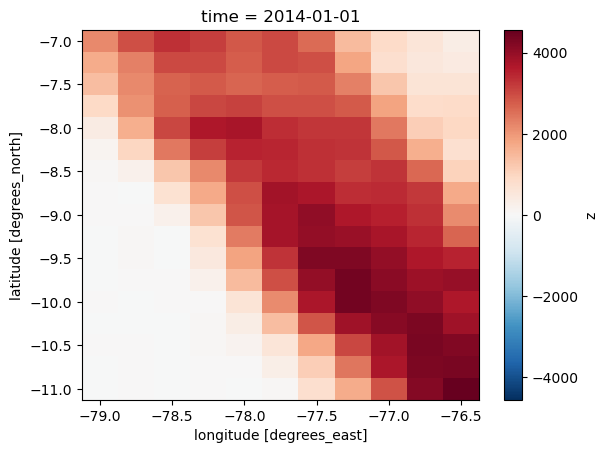

In [7]:
(ds['z'][0] / 9.80665).plot()
print((ds['z'][0].values / 9.80665).max())

Este es el DEM que usan para ejecutar el modelo global para genera los datos ERA5. 
* ¿Por qué los valores van hasta ~4500?
*  ¿Cuál es el [pico](https://es.wikipedia.org/wiki/Huascar%C3%A1n) más alto en Perú? 

## Datos geográficos de nuestra estación climática

In [8]:
## Lon, Lat, Elevacion

EMA06 = [-77.903333, -8.565889, 2759]
EMA15 = [-77.688333, -9.222450, 2118]

## Visualizar la localizacion de las estaciones

In [9]:
from matplotlib import pyplot as plt
from cartopy.io.shapereader import Reader as ShapeReader
from cartopy.crs import PlateCarree

In [10]:
projection = PlateCarree()

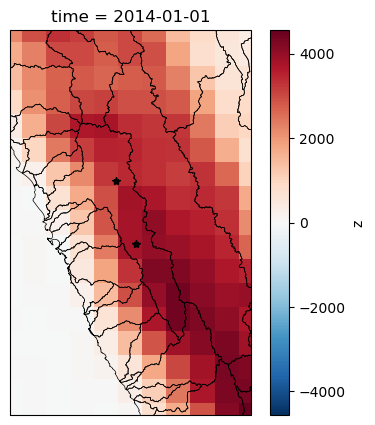

In [11]:
# Genere una figura (establezca su tamaño (ancho, alto) en pulgadas) y ejes usando Cartopy
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=projection)

# Aquí definimos los limites de lon y lat de nuestra figura
ax.set_extent([-79, -76.5, -11, -7], crs=projection)

# Podemos agregar una información vectorial como un shapefile usando ´add_geometries´
fname = '../data/shapefiles/UH.shp'
ax.add_geometries(ShapeReader(fname).geometries(), facecolor='none', edgecolor='k', lw=0.5, crs=projection)

(ds['z'][0] / 9.80665).plot(ax=ax)

ax.plot(EMA06[0],EMA06[1], 'k*')
ax.plot(EMA15[0],EMA15[1], 'k*')

## Selección para una ubicación 

In [12]:
#df = ds.sel(longitude=lon, 
#            latitude=lat, 
#            method='nearest')

In [13]:
df

NameError: name 'df' is not defined

## Convertimos para un **`dataframe`**

In [ ]:
df = df.to_dataframe()
df

,longitude,latitude,z,u10,v10,t2m,tp
time,,,,,,,
1960-01-01,-76.25,-13.75,495.257812,1.712164,2.557608,295.048828,0.000126
1960-02-01,-76.25,-13.75,495.257812,1.719407,1.938375,294.937683,0.000080
1960-03-01,-76.25,-13.75,495.257812,1.489329,2.567127,294.616028,0.000005
1960-04-01,-76.25,-13.75,495.257812,1.437099,2.936696,293.189545,0.000009
1960-05-01,-76.25,-13.75,495.257812,1.301378,2.930183,290.973602,0.000035
...,...,...,...,...,...,...,...
2020-08-01,-76.25,-13.75,495.257812,1.195917,4.298684,289.534088,0.000019
2020-09-01,-76.25,-13.75,495.257812,1.421874,4.131598,289.541443,0.000023
2020-10-01,-76.25,-13.75,495.257812,1.687706,3.650553,290.684723,0.000014


## Vamos aplicar un downscaling estadístico

In [ ]:
g       = 9.80665
hgt_era = (df['z'].values[0]/g)
hgt_aws = elev
df['t2m_corr'] = df['t2m'].values + (hgt_aws - hgt_era) * -0.009
df[['t2m', 't2m_corr']] = df[['t2m', 't2m_corr']] - 273.16
df

,longitude,latitude,z,u10,v10,t2m,tp,t2m_corr
time,,,,,,,,
1960-01-01,-76.25,-13.75,495.257812,1.712164,2.557608,21.888824,0.000126,22.236237
1960-02-01,-76.25,-13.75,495.257812,1.719407,1.938375,21.777679,0.000080,22.125092
1960-03-01,-76.25,-13.75,495.257812,1.489329,2.567127,21.456024,0.000005,21.803436
1960-04-01,-76.25,-13.75,495.257812,1.437099,2.936696,20.029541,0.000009,20.376953
1960-05-01,-76.25,-13.75,495.257812,1.301378,2.930183,17.813599,0.000035,18.161011
...,...,...,...,...,...,...,...,...
2020-08-01,-76.25,-13.75,495.257812,1.195917,4.298684,16.374084,0.000019,16.721497
2020-09-01,-76.25,-13.75,495.257812,1.421874,4.131598,16.381439,0.000023,16.728851
2020-10-01,-76.25,-13.75,495.257812,1.687706,3.650553,17.524719,0.000014,17.872131


In [ ]:
# Función mejorada para sumar columnas donde contienen nan's
def nansumwrapper(a, **kwargs):
    if np.isnan(a).all():
        return np.nan
    else:
        return np.nansum(a, **kwargs)

## Leemos nuestros datos observados

### Vamos usar **`1M`** para promediar mensualmente

In [ ]:
import pandas as pd

In [ ]:
f_aws = pd.read_csv('../data/EMA06_Corongo.dat', delimiter='\t', index_col=['Fecha'], 
                 parse_dates=['Fecha'])

<AxesSubplot:xlabel='Fecha'>

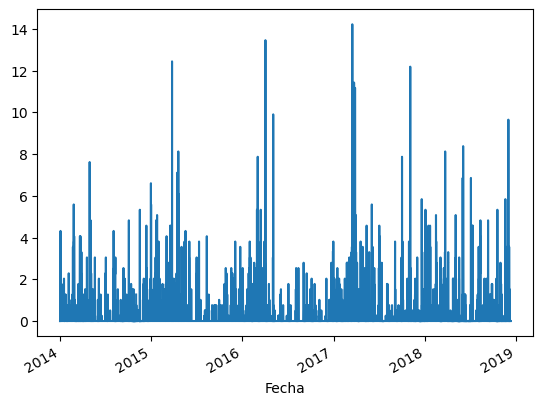

In [ ]:
f_aws['Precip'].plot()

In [ ]:
df_aws = pd.read_csv('../../data/3117033.csv', delimiter=',', index_col=['DATE'], 
                 parse_dates=['DATE']).resample('1M').agg({'PRCP':nansumwrapper, 'TAVG':np.mean, 'TMIN':np.mean, 'TMAX':np.mean})
df_aws

,PRCP,TAVG,TMIN,TMAX
DATE,,,,
1963-03-31,NaN,22.150000,17.151852,27.108000
1963-04-30,NaN,20.832000,16.333333,25.991304
1963-05-31,NaN,19.395833,15.052174,24.495238
1963-06-30,NaN,16.800000,12.508000,21.764286
1963-07-31,NaN,16.461290,12.086667,21.042308
...,...,...,...,...
2022-06-30,0.0,16.206667,12.958333,20.022222
2022-07-31,0.0,15.861290,12.766667,19.060000
2022-08-31,0.0,15.500000,12.843478,18.692308


### Vamos usar **`1MS`** para promediar mensualmente

In [ ]:
df_aws1 = pd.read_csv('../../data/3117033.csv', delimiter=',', index_col=['DATE'], 
                 parse_dates=['DATE']).resample('1MS').agg({'PRCP':nansumwrapper, 'TAVG':np.mean, 'TMIN':np.mean, 'TMAX':np.mean})
df_aws1

,PRCP,TAVG,TMIN,TMAX
DATE,,,,
1963-03-01,NaN,22.150000,17.151852,27.108000
1963-04-01,NaN,20.832000,16.333333,25.991304
1963-05-01,NaN,19.395833,15.052174,24.495238
1963-06-01,NaN,16.800000,12.508000,21.764286
1963-07-01,NaN,16.461290,12.086667,21.042308
...,...,...,...,...
2022-06-01,0.0,16.206667,12.958333,20.022222
2022-07-01,0.0,15.861290,12.766667,19.060000
2022-08-01,0.0,15.500000,12.843478,18.692308


¿Cuál es la diferencia?

## Veamos las tres series usados **`matplotlib`**

In [ ]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='DATE'>

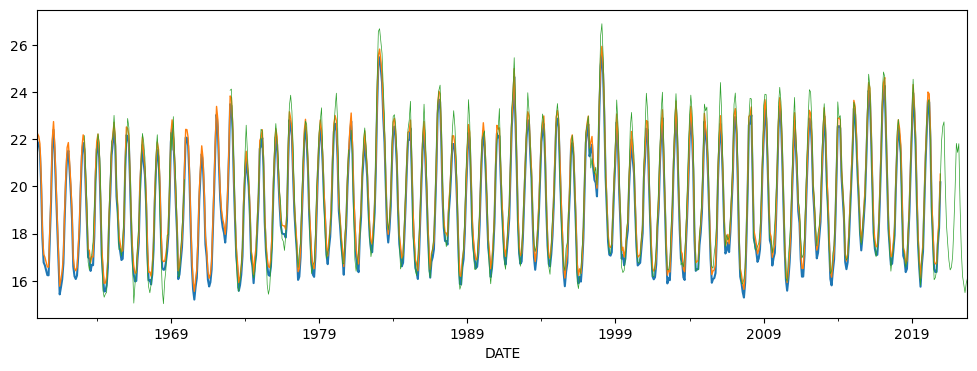

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(12, 4))
df['t2m'].plot(ax=ax, linewidth=1.5) # ERA5 sin corregir
df['t2m_corr'].plot(ax=ax, linewidth=1.0) # ERA5 corregido
df_aws1['TAVG'].plot(ax=ax,linewidth=0.5)


## Ahora vamos juntar los **`dataframes`**

In [ ]:
df

,longitude,latitude,z,u10,v10,t2m,tp,t2m_corr
time,,,,,,,,
1960-01-01,-76.25,-13.75,495.257812,1.712164,2.557608,21.888824,0.000126,22.236237
1960-02-01,-76.25,-13.75,495.257812,1.719407,1.938375,21.777679,0.000080,22.125092
1960-03-01,-76.25,-13.75,495.257812,1.489329,2.567127,21.456024,0.000005,21.803436
1960-04-01,-76.25,-13.75,495.257812,1.437099,2.936696,20.029541,0.000009,20.376953
1960-05-01,-76.25,-13.75,495.257812,1.301378,2.930183,17.813599,0.000035,18.161011
...,...,...,...,...,...,...,...,...
2020-08-01,-76.25,-13.75,495.257812,1.195917,4.298684,16.374084,0.000019,16.721497
2020-09-01,-76.25,-13.75,495.257812,1.421874,4.131598,16.381439,0.000023,16.728851
2020-10-01,-76.25,-13.75,495.257812,1.687706,3.650553,17.524719,0.000014,17.872131


In [ ]:
df_aws1

,PRCP,TAVG,TMIN,TMAX
DATE,,,,
1963-03-01,NaN,22.150000,17.151852,27.108000
1963-04-01,NaN,20.832000,16.333333,25.991304
1963-05-01,NaN,19.395833,15.052174,24.495238
1963-06-01,NaN,16.800000,12.508000,21.764286
1963-07-01,NaN,16.461290,12.086667,21.042308
...,...,...,...,...
2022-06-01,0.0,16.206667,12.958333,20.022222
2022-07-01,0.0,15.861290,12.766667,19.060000
2022-08-01,0.0,15.500000,12.843478,18.692308


In [ ]:
df_aws

,PRCP,TAVG,TMIN,TMAX
DATE,,,,
1963-03-31,NaN,22.150000,17.151852,27.108000
1963-04-30,NaN,20.832000,16.333333,25.991304
1963-05-31,NaN,19.395833,15.052174,24.495238
1963-06-30,NaN,16.800000,12.508000,21.764286
1963-07-31,NaN,16.461290,12.086667,21.042308
...,...,...,...,...
2022-06-30,0.0,16.206667,12.958333,20.022222
2022-07-31,0.0,15.861290,12.766667,19.060000
2022-08-31,0.0,15.500000,12.843478,18.692308


In [ ]:
df_all = pd.merge(df, df_aws1, how='left', left_index=True, right_index=True)
df_all

,longitude,latitude,z,u10,v10,t2m,tp,t2m_corr,PRCP,TAVG,TMIN,TMAX
time,,,,,,,,,,,,
1960-01-01,-76.25,-13.75,495.257812,1.712164,2.557608,21.888824,0.000126,22.236237,NaN,NaN,NaN,NaN
1960-02-01,-76.25,-13.75,495.257812,1.719407,1.938375,21.777679,0.000080,22.125092,NaN,NaN,NaN,NaN
1960-03-01,-76.25,-13.75,495.257812,1.489329,2.567127,21.456024,0.000005,21.803436,NaN,NaN,NaN,NaN
1960-04-01,-76.25,-13.75,495.257812,1.437099,2.936696,20.029541,0.000009,20.376953,NaN,NaN,NaN,NaN
1960-05-01,-76.25,-13.75,495.257812,1.301378,2.930183,17.813599,0.000035,18.161011,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-76.25,-13.75,495.257812,1.195917,4.298684,16.374084,0.000019,16.721497,NaN,16.138710,12.967857,NaN
2020-09-01,-76.25,-13.75,495.257812,1.421874,4.131598,16.381439,0.000023,16.728851,NaN,16.453333,12.978947,19.150000
2020-10-01,-76.25,-13.75,495.257812,1.687706,3.650553,17.524719,0.000014,17.872131,NaN,17.716129,14.859091,21.892308


Tenga en cuenta que se está servado la serie temporal del **ERA5** por ser más completa!!

## Correlación de los datos

Vamos a crear un dataframe que contenga solo los datos de temperatura observada y ERA5. Además vamos a eliminar los valores faltantes.

In [ ]:
temp2 = df_all[['t2m_corr', 'TAVG']].dropna()
temp2.columns = ['MOD', 'OBS']
temp2

,MOD,OBS
time,,
1963-03-01,21.907104,22.150000
1963-04-01,20.380859,20.832000
1963-05-01,18.888062,19.395833
1963-06-01,17.350647,16.800000
1963-07-01,17.284729,16.461290
...,...,...
2020-08-01,16.721497,16.138710
2020-09-01,16.728851,16.453333
2020-10-01,17.872131,17.716129


## Importamos funciones disponibles de **`sklearn`** y **`scipy`**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde

Declaramos dos variables para facilitar más adelante.

In [ ]:
y1 = temp2['OBS'].values
y2 = temp2['MOD'].values

Creamos una variable que contenga la información del index y hacemos que sea aleatorio. Además vamos a generar una variable que con potencia 10 para usar en la figura de dispersión.

In [ ]:
idxs = np.arange(len(y1))
np.random.shuffle(idxs)
n_toplot=10**10

Vamos hacer un redimensionado de nuestros vectores de temperatura observada y ERA 

In [ ]:
y_expected = y1.reshape(-1)[idxs[:n_toplot]]
y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

Creamos una nueva matriz que contenga los datos redimensionados.

In [ ]:
xy = np.vstack([y_expected, y_predicted])
print(xy)

[[20.36666667 23.29655172 18.46451613 ... 16.47       23.70645161
  16.66774194]
 [20.53851318 23.00119019 18.49356079 ... 17.38015747 23.3661499
  16.61032104]]


Ahora usamos la función **`gaussian_kde`** para estimar la densidad de nuestros datos.

In [ ]:
z = gaussian_kde(xy)(xy)

Ordenamos los puntos por densidad, de modo que los puntos más densos se tracen en último lugar

In [ ]:
idx = z.argsort()
y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]

### Generar nuestra figura de densidad de dispersión en función de su densidad

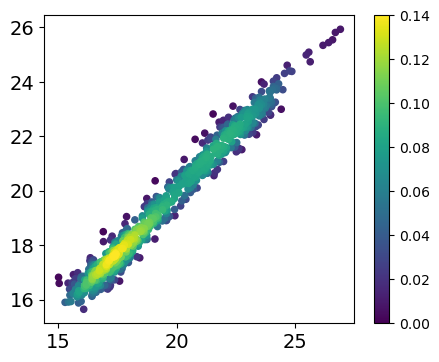

In [ ]:
fig = plt.figure(figsize=(5,4))
sc = plt.scatter(y_plt, ann_plt, c=z, s=20)

# Agregamos colorbar y ajustamos de 0 a 0.14
plt.colorbar(sc)
plt.clim(0,0.14)
plt.tick_params(labelsize=14)


Miremos cómo va quedando nuestra figura!!

### Mejoramos nuestra figura

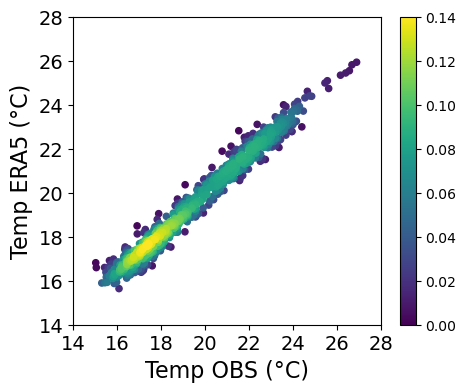

In [ ]:
fig = plt.figure(figsize=(5,4))
sc = plt.scatter(y_plt, ann_plt, c=z, s=20)

# Agregamos colorbar y ajustamos de 0 a 0.14
plt.colorbar(sc)
plt.clim(0,0.14)
plt.tick_params(labelsize=14)

# Agregamos las etiquetas a los ejes y damos ajustes
plt.ylabel('Temp ERA5 (°C)', fontsize=16)
plt.xlabel('Temp OBS (°C)', fontsize=16)
plt.xlim(14, 28)
plt.ylim(14, 28)

# Podemos colocar las etiquetas deseada
plt.gca().set_box_aspect(1)
plt.xticks(np.arange(14,30,2))
plt.yticks(np.arange(14,30,2))
print('')

### Agregamos la línea de regresión y algunos indicadores estadísticos

Creamos nuestro modelo lineal y un vector que va desde 13°C hasta 29°C.

In [ ]:
reg = LinearRegression().fit(y1.reshape(-1, 1),y2)
print(reg)
x_int = np.arange(13,29,0.1)
print(x_int)

LinearRegression()
[13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3
 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5 15.6 15.7
 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7 16.8 16.9 17.  17.1
 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1 18.2 18.3 18.4 18.5
 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5 19.6 19.7 19.8 19.9
 20.  20.1 20.2 20.3 20.4 20.5 20.6 20.7 20.8 20.9 21.  21.1 21.2 21.3
 21.4 21.5 21.6 21.7 21.8 21.9 22.  22.1 22.2 22.3 22.4 22.5 22.6 22.7
 22.8 22.9 23.  23.1 23.2 23.3 23.4 23.5 23.6 23.7 23.8 23.9 24.  24.1
 24.2 24.3 24.4 24.5 24.6 24.7 24.8 24.9 25.  25.1 25.2 25.3 25.4 25.5
 25.6 25.7 25.8 25.9 26.  26.1 26.2 26.3 26.4 26.5 26.6 26.7 26.8 26.9
 27.  27.1 27.2 27.3 27.4 27.5 27.6 27.7 27.8 27.9 28.  28.1 28.2 28.3
 28.4 28.5 28.6 28.7 28.8 28.9]


Calculamos el error medio cuadrático y el coeficiente de determinación. Los guardamos en un string.

In [ ]:
textstr = '\n'.join((
r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
print(textstr)

$RMSE=0.24$
$R^2=0.96$


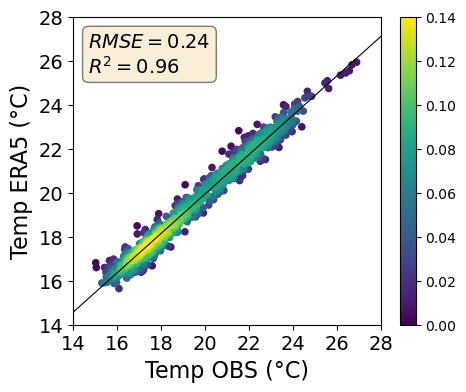

In [ ]:
fig = plt.figure(figsize=(5,4))
sc = plt.scatter(y_plt, ann_plt, c=z, s=20)

# Agregamos colorbar y ajustamos de 0 a 0.14
plt.colorbar(sc)
plt.clim(0,0.14)
plt.tick_params(labelsize=14)

# Agregamos las etiquetas a los ejes y damos ajustes
plt.ylabel('Temp ERA5 (°C)', fontsize=16)
plt.xlabel('Temp OBS (°C)', fontsize=16)
plt.xlim(14, 28)
plt.ylim(14, 28)

# Podemos colocar las etiquetas deseada
plt.gca().set_box_aspect(1)
plt.xticks(np.arange(14,30,2))
plt.yticks(np.arange(14,30,2))

# Agregamos la regresión lineal
plt.plot(x_int, reg.intercept_ + reg.coef_ * x_int, linewidth=0.8, color='k', linestyle ='-')

# Vamos agregar un caja para que se muestre los indicadores estadísticos. Aquí configuramos los propiedades de la caja
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Ahora podemos agregar nuestros indicadores estadísticos
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Finalmente guardamos nuestra figura
fig.savefig('fig/Temp_corr_1963_2020.png', dpi = 200, facecolor='w', bbox_inches = 'tight', 
            pad_inches = 0.1)

## Retornar al [indice](./../indice.md)